In [7]:
import pandas as pd

df = pd.read_csv(
    '202401-202406-citibike-tripdata-cleaned-normalized.csv',
    dtype={
        'start_station_id': str,
        'end_station_id': str
    },
    low_memory=False
)
df.head()

,ended_at,start_station_name,member_casual,end_lng,started_at,start_station_id,end_station_name,start_lat,start_lng,end_lat,end_station_id,ride_id,rideable_type,start_station_id_norm,end_station_id_norm,start_id,end_id,bike_type,VIP
0,2024-01-22 18:48:10.708,Frederick Douglass Blvd & W 145 St,member,-73.951878,2024-01-22 18:43:19.012,7954.12,St Nicholas Ave & W 126 St,40.823072,-73.941738,40.811432,7756.10,5078F3D302000BD2,electric_bike,7954.12,7756.1,1830,1747,1,1
1,2024-01-11 19:47:36.007,W 54 St & 6 Ave,member,-73.954823,2024-01-11 19:19:18.721,6771.13,E 74 St & 1 Ave,40.761822,-73.977036,40.768974,6953.08,814337105D37302A,electric_bike,6771.13,6953.08,1422,1506,1,1
2,2024-01-30 19:32:49.857,E 11 St & Ave B,casual,-74.008515,2024-01-30 19:17:41.693,5659.11,W 10 St & Washington St,40.727592,-73.979751,40.733424,5847.06,A33A920E2B10710C,electric_bike,5659.11,5847.06,902,958,1,0
3,2024-01-27 11:38:01.213,W 54 St & 6 Ave,member,-73.954823,2024-01-27 11:27:01.759,6771.13,E 74 St & 1 Ave,40.761779,-73.977144,40.768974,6953.08,A3A5FC0DD7D34D74,electric_bike,6771.13,6953.08,1422,1506,1,1
4,2024-01-16 15:29:26.156,Madison Ave & E 99 St,member,-73.954823,2024-01-16 15:15:41.000,7443.01,E 74 St & 1 Ave,40.789808,-73.952214,40.768974,6953.08,6F96728ECEFBDAA4,electric_bike,7443.01,6953.08,1638,1506,1,1


Starting CitiBike flow forecasting with improved exogenous variable handling...
Net flow calculation complete. Shape: (5457978, 7)

Sample of net flow data with exogenous variables:
   station_id                hour  net_flow  outflow_bike_type_avg  \
0  190 Morgan 2024-01-10 09:00:00       1.0                    0.5   
1  190 Morgan 2024-02-12 13:00:00       1.0                    0.5   
2  190 Morgan 2024-02-23 09:00:00       1.0                    0.5   
3  190 Morgan 2024-02-23 12:00:00      -1.0                    1.0   
4  190 Morgan 2024-04-12 09:00:00       1.0                    0.5   

   outflow_VIP_avg  inflow_bike_type_avg  inflow_VIP_avg  
0              0.5                   1.0             1.0  
1              0.5                   1.0             1.0  
2              0.5                   1.0             1.0  
3              1.0                   0.5             0.5  
4              0.5                   1.0             1.0  

Top 10 stations with largest net flow (imb

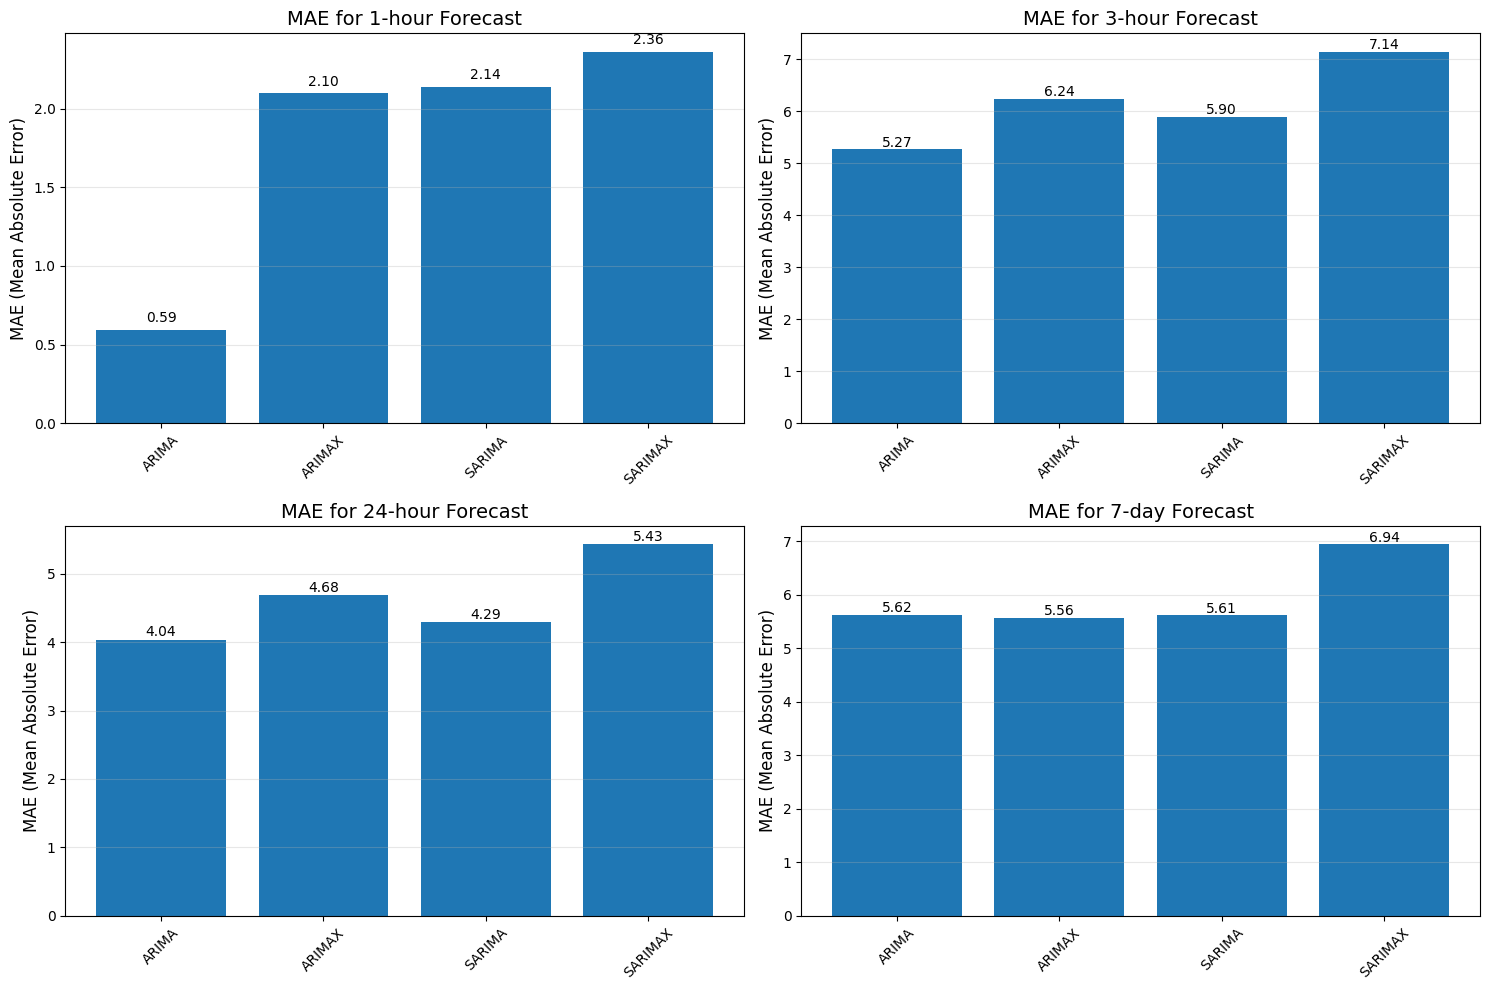


MAE Comparison Across All Models and Horizons:
Model    ARIMA  ARIMAX  SARIMA  SARIMAX
Horizon                                
1-hour    0.59    2.10    2.14     2.36
3-hour    5.27    6.24    5.90     7.14
24-hour   4.04    4.68    4.29     5.43
7-day     5.62    5.56    5.61     6.94

Better performing model overall based on MAE: ARIMA

Generating 7-day forecast using ARIMA...

Forecast Summary for Station 6847.02
  Time Horizon  Total Net Flow  Average Per Hour
0       1-hour       -0.407007         -0.407007
1       3-hour       -2.522694         -0.840898
2      24-hour      -29.677820         -1.236576
3        7-day     -216.464190         -1.288477


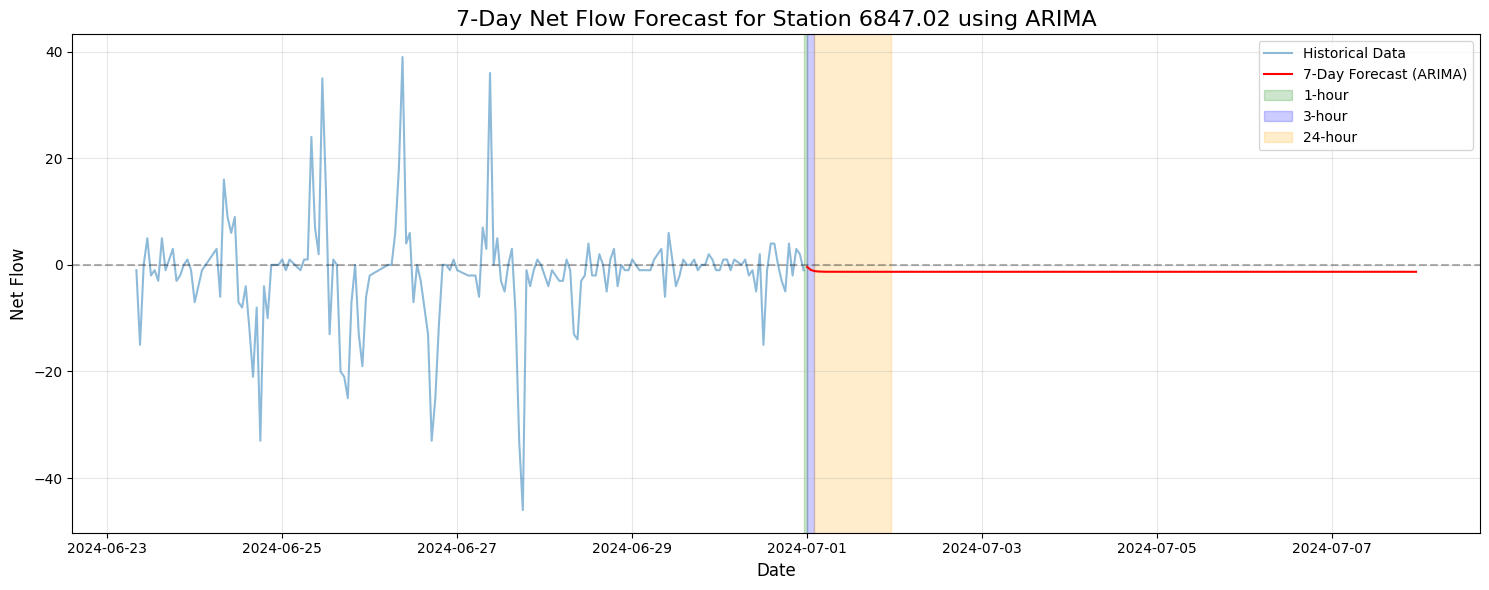

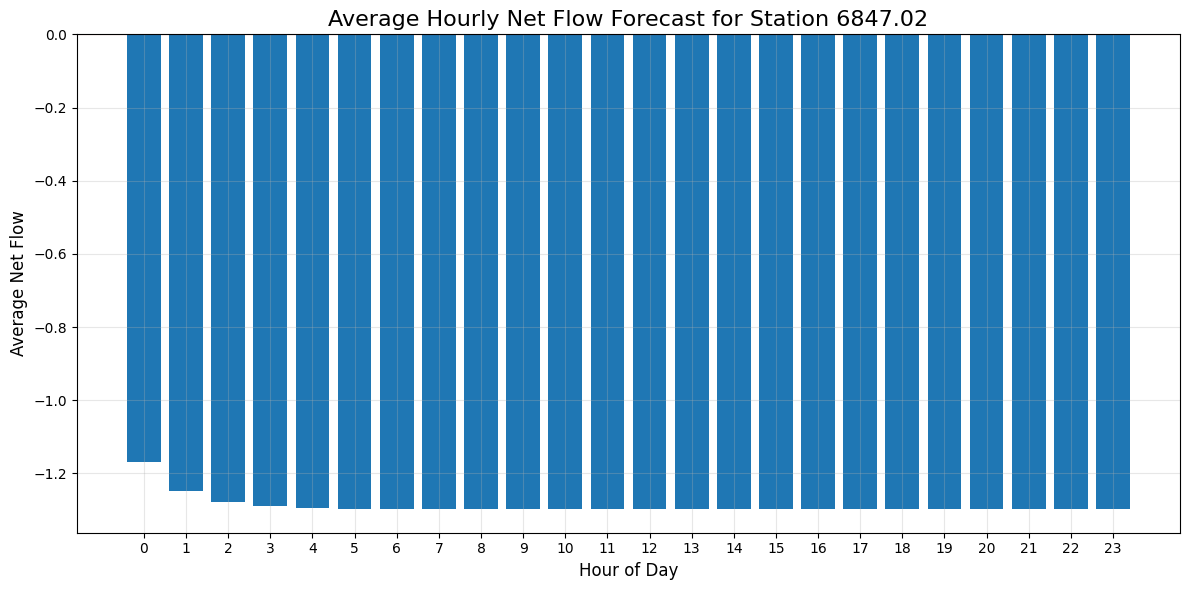


Forecast saved to station_6847.02_forecast_ARIMA.csv

Rebalancing Analysis:
Maximum bike depletion: 216.5 bikes at 2024-07-07 23:00:00
  - Station may need bikes added at this time


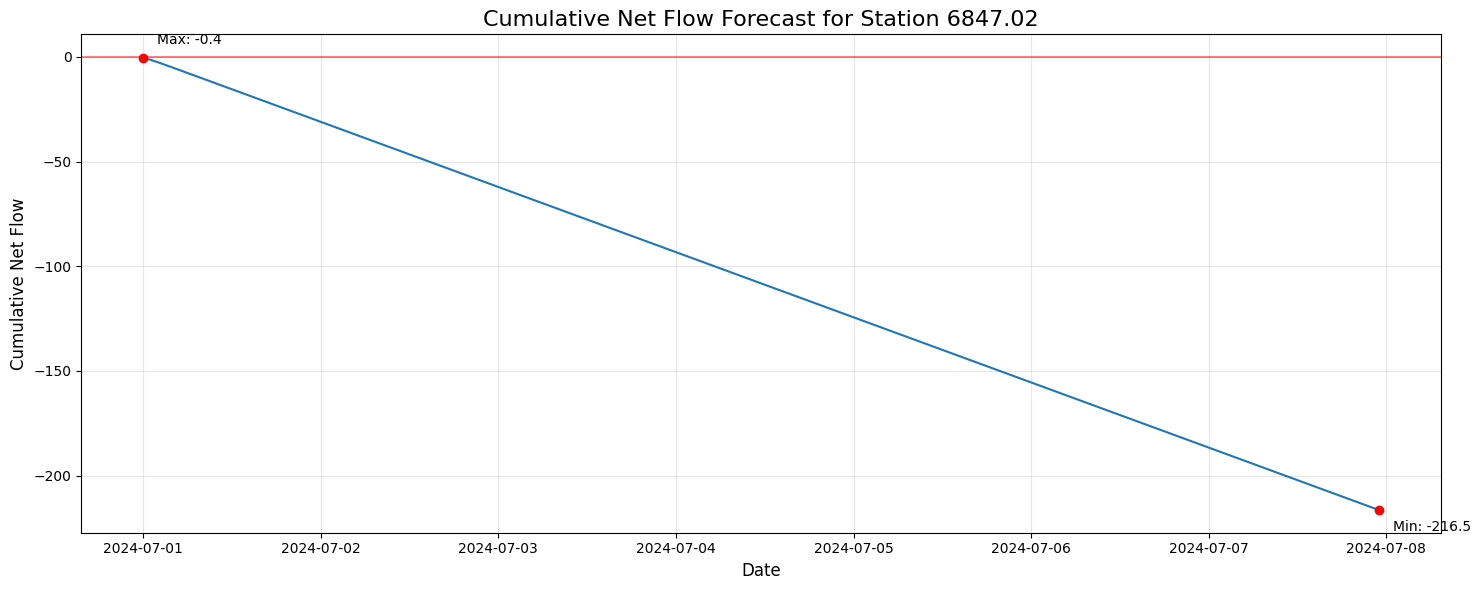

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Define MAPE function with better handling of zero values
def mean_absolute_percentage_error(y_true, y_pred):
    """
    Calculate Mean Absolute Percentage Error (MAPE) with better handling of zero values
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Only include non-zero actual values in calculation
    non_zero_indices = np.abs(y_true) > 0.5  # Using 0.5 as threshold rather than exactly 0
    
    if sum(non_zero_indices) == 0:
        return np.nan  # Return NaN if no non-zero values
    
    # Calculate percentage errors only for non-zero elements
    percentage_errors = np.abs((y_true[non_zero_indices] - y_pred[non_zero_indices]) / 
                               np.abs(y_true[non_zero_indices])) * 100
    
    # Cap extremely large errors at 1000%
    percentage_errors = np.minimum(percentage_errors, 1000.0)
    
    return np.mean(percentage_errors)

# Function to safely access Series elements by index position
def safe_get_element(series, position):
    """Safely get element from a pandas Series by position, even if index is not standard"""
    if isinstance(series, pd.Series):
        if position < len(series):
            return series.iloc[position]
        else:
            return np.nan
    else:
        # If it's a numpy array, list, or other sequence
        if position < len(series):
            return series[position]
        else:
            return np.nan

# Function to safely sum elements in a Series or array
def safe_sum(series, n_elements=None):
    """Safely sum elements in a Series or array"""
    if n_elements is not None:
        if isinstance(series, pd.Series):
            return series.iloc[:n_elements].sum()
        else:
            return sum(series[:n_elements])
    else:
        if isinstance(series, pd.Series):
            return series.sum()
        else:
            return sum(series)

print("Starting CitiBike flow forecasting with improved exogenous variable handling...")

# Step 1: Convert timestamp columns to datetime using flexible parsing
df['start_time'] = pd.to_datetime(df['started_at'], format='mixed')
df['end_time'] = pd.to_datetime(df['ended_at'], format='mixed')

# Step 2: Remove rows with missing station data
df_clean = df.dropna(subset=['start_station_id_norm', 'end_station_id_norm'])

# Step 3: Make sure station_id is treated consistently as the same type
df_clean['start_station_id_norm'] = df_clean['start_station_id_norm'].astype(str)
df_clean['end_station_id_norm'] = df_clean['end_station_id_norm'].astype(str)

# Step 4: Create exogenous variables aggregated by hour
# First for outflow
outflow_exog = df_clean.groupby([df_clean['start_station_id_norm'],
                               pd.Grouper(key='start_time', freq='h')])[['bike_type', 'VIP']].mean()
outflow_exog['count'] = df_clean.groupby([df_clean['start_station_id_norm'],
                                      pd.Grouper(key='start_time', freq='h')]).size()
outflow_exog.index.names = ['station_id', 'hour']
outflow_exog = outflow_exog.reset_index()

# Then for inflow
inflow_exog = df_clean.groupby([df_clean['end_station_id_norm'],
                              pd.Grouper(key='end_time', freq='h')])[['bike_type', 'VIP']].mean()
inflow_exog['count'] = df_clean.groupby([df_clean['end_station_id_norm'],
                                     pd.Grouper(key='end_time', freq='h')]).size()
inflow_exog.index.names = ['station_id', 'hour']
inflow_exog = inflow_exog.reset_index()

# Step 5: Calculate outflow (bikes leaving) for each station by hour
outflow = df_clean.groupby([df_clean['start_station_id_norm'],
                           pd.Grouper(key='start_time', freq='h')]).size()
outflow.index.names = ['station_id', 'hour']
outflow = outflow.reset_index(name='outflow')

# Step 6: Calculate inflow (bikes arriving) for each station by hour
inflow = df_clean.groupby([df_clean['end_station_id_norm'],
                          pd.Grouper(key='end_time', freq='h')]).size()
inflow.index.names = ['station_id', 'hour']
inflow = inflow.reset_index(name='inflow')

# Step 7: Merge inflow and outflow data and calculate net flow
merged = pd.merge(outflow, inflow, on=['station_id', 'hour'], how='outer').fillna(0)
merged['net_flow'] = merged['inflow'] - merged['outflow']

# Step 8: Create the final net_flow DataFrame
net_flow = merged[['station_id', 'hour', 'net_flow']]

# Step 9: Merge with exogenous variables
# Merge outflow exogenous variables
net_flow = pd.merge(net_flow, outflow_exog[['station_id', 'hour', 'bike_type', 'VIP']], 
                    on=['station_id', 'hour'], how='left', suffixes=('', '_outflow'))

# Merge inflow exogenous variables
net_flow = pd.merge(net_flow, inflow_exog[['station_id', 'hour', 'bike_type', 'VIP']], 
                   on=['station_id', 'hour'], how='left', suffixes=('_outflow', '_inflow'))

# Rename columns for clarity
net_flow.rename(columns={'bike_type_outflow': 'outflow_bike_type_avg',
                         'VIP_outflow': 'outflow_VIP_avg',
                         'bike_type_inflow': 'inflow_bike_type_avg',
                         'VIP_inflow': 'inflow_VIP_avg'}, inplace=True)

# Fill NA values for exogenous variables 
# (stations with no outflow or inflow in a particular hour)
net_flow.fillna({'outflow_bike_type_avg': 0.5, 'outflow_VIP_avg': 0.5,
                 'inflow_bike_type_avg': 0.5, 'inflow_VIP_avg': 0.5}, inplace=True)

print("Net flow calculation complete. Shape:", net_flow.shape)
print("\nSample of net flow data with exogenous variables:")
print(net_flow.head(5))

# Step 10: Find the stations with the largest absolute net flow
# First, calculate the total net flow for each station
station_flow = net_flow.groupby('station_id')['net_flow'].sum().reset_index()
# Calculate absolute net flow to find stations with largest imbalance in either direction
station_flow['abs_net_flow'] = station_flow['net_flow'].abs()
# Sort by absolute net flow and get top 10
top_10_flow_stations = station_flow.sort_values('abs_net_flow', ascending=False).head(10)

print("\nTop 10 stations with largest net flow (imbalance):")
print(top_10_flow_stations)

# Step 11: Get the station with the largest net flow imbalance
if not top_10_flow_stations.empty:
    target_station = top_10_flow_stations.iloc[0]['station_id']
    target_flow = top_10_flow_stations.iloc[0]['net_flow']
    print(f"\nAnalyzing station with the largest net flow imbalance: {target_station}")
    print(f"Total net flow: {target_flow:.2f} bikes " + 
          ("gained" if target_flow > 0 else "lost") + 
          " over the entire period")
    
    # Filter data for the target station
    station_data = net_flow[net_flow['station_id'] == target_station].copy()
    
    # Ensure data is sorted by time
    station_data = station_data.sort_values('hour')
    
    # Create time-based features
    station_data['hour_of_day'] = station_data['hour'].dt.hour
    station_data['day_of_week'] = station_data['hour'].dt.dayofweek
    
    # Step 12: Split data into training and testing sets
    # Ensure exactly 7 days (168 hours) for testing if possible
    if len(station_data) >= 168:
        # Get the last 168 hours for testing
        test = station_data.iloc[-168:].copy()
        train = station_data.iloc[:-168].copy()
        split_date = test['hour'].min()
    else:
        # If we don't have 168 hours, use what we have but print a warning
        print(f"WARNING: Not enough data for a full 7-day test period. Using all {len(station_data)} available hours.")
        # Use 80% for training, 20% for testing
        train_size = int(len(station_data) * 0.8)
        train = station_data.iloc[:train_size].copy()
        test = station_data.iloc[train_size:].copy()
        split_date = test['hour'].min()
    
    print(f"Training data size: {train.shape[0]} hours")
    print(f"Testing data size: {test.shape[0]} hours")
    
    # Step 13: Prepare time series data for modeling
    ts_data = train.set_index('hour')['net_flow']
    ts_data = ts_data.resample('H').mean().fillna(method='ffill')
    
    # ---------------------------------------------------------------
    # IMPROVED EXOGENOUS VARIABLE PREPARATION
    # ---------------------------------------------------------------
    
    # Create simplified exogenous variables with less dimensionality
    # For training
    exog_train = pd.DataFrame()
    
    # 1. Use VIP and bike_type averages
    exog_train['vip_ratio'] = train['outflow_VIP_avg'] * 0.5 + train['inflow_VIP_avg'] * 0.5
    exog_train['electric_ratio'] = train['outflow_bike_type_avg'] * 0.5 + train['inflow_bike_type_avg'] * 0.5
    
    # 2. Add simplified time indicators instead of many dummy variables
    exog_train['is_weekend'] = (train['day_of_week'] >= 5).astype(int)
    exog_train['is_morning_rush'] = ((train['hour_of_day'] >= 7) & (train['hour_of_day'] <= 9)).astype(int)
    exog_train['is_evening_rush'] = ((train['hour_of_day'] >= 16) & (train['hour_of_day'] <= 19)).astype(int)
    exog_train['hour_sin'] = np.sin(2 * np.pi * train['hour_of_day'] / 24)
    exog_train['hour_cos'] = np.cos(2 * np.pi * train['hour_of_day'] / 24)
    
    # For testing
    exog_test = pd.DataFrame()
    exog_test['vip_ratio'] = test['outflow_VIP_avg'] * 0.5 + test['inflow_VIP_avg'] * 0.5
    exog_test['electric_ratio'] = test['outflow_bike_type_avg'] * 0.5 + test['inflow_bike_type_avg'] * 0.5
    exog_test['is_weekend'] = (test['day_of_week'] >= 5).astype(int)
    exog_test['is_morning_rush'] = ((test['hour_of_day'] >= 7) & (test['hour_of_day'] <= 9)).astype(int)
    exog_test['is_evening_rush'] = ((test['hour_of_day'] >= 16) & (test['hour_of_day'] <= 19)).astype(int)
    exog_test['hour_sin'] = np.sin(2 * np.pi * test['hour_of_day'] / 24)
    exog_test['hour_cos'] = np.cos(2 * np.pi * test['hour_of_day'] / 24)
    
    # 3. Standardize numerical features for better convergence
    scaler = StandardScaler()
    numerical_cols = ['vip_ratio', 'electric_ratio', 'hour_sin', 'hour_cos']
    exog_train[numerical_cols] = scaler.fit_transform(exog_train[numerical_cols])
    exog_test[numerical_cols] = scaler.transform(exog_test[numerical_cols])
    
    # Check for multicollinearity
    print("\nChecking for multicollinearity in exogenous variables...")
    corr_matrix = exog_train.corr().abs()
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    high_corr = [column for column in upper_tri.columns if any(upper_tri[column] > 0.8)]
    
    if high_corr:
        print(f"High correlation found between: {high_corr}")
        # If there is multicollinearity, we might drop some variables
        # But for now we'll just note it and proceed
    else:
        print("No significant multicollinearity detected.")
    
    # Define function to generate future exogenous variables
    def generate_future_exog(start_date, periods):
        """Generate exogenous variables for future dates"""
        future_dates = pd.date_range(start=start_date, periods=periods, freq='H')
        future_exog = pd.DataFrame()
        
        # Extract hour and day features
        hours = [d.hour for d in future_dates]
        days = [d.dayofweek for d in future_dates]
        
        # Create time-based features
        future_exog['is_weekend'] = [1 if d >= 5 else 0 for d in days]
        future_exog['is_morning_rush'] = [1 if h >= 7 and h <= 9 else 0 for h in hours]
        future_exog['is_evening_rush'] = [1 if h >= 16 and h <= 19 else 0 for h in hours]
        future_exog['hour_sin'] = np.sin(2 * np.pi * np.array(hours) / 24)
        future_exog['hour_cos'] = np.cos(2 * np.pi * np.array(hours) / 24)
        
        # Use average VIP and bike_type ratios from training data
        future_exog['vip_ratio'] = exog_train['vip_ratio'].mean()
        future_exog['electric_ratio'] = exog_train['electric_ratio'].mean()
        
        # Apply same scaling
        future_exog[numerical_cols] = scaler.transform(future_exog[numerical_cols])
        
        return future_exog, future_dates
    
    # Step A: Define forecast horizons
    horizons = {
        '1-hour': 1,
        '3-hour': 3,
        '24-hour': 24,
        '7-day': 168  # Using exact 168 hours for 7 days
    }
    
    # Step B: Create dataframe to store evaluation results
    evaluation_results = pd.DataFrame(
        columns=['Model', 'Horizon', 'RMSE', 'MAE', 'MAPE']
    )
    
    # Step C: Fit ARIMA model and evaluate on different horizons
    print("\nFitting ARIMA model...")
    try:
        # Fit ARIMA model
        arima_model = ARIMA(ts_data, order=(1, 1, 1))
        arima_results = arima_model.fit()
        
        # Get the last timestamp in our data for forecasting
        last_timestamp = station_data['hour'].max()
        
        # Generate and evaluate forecasts for different horizons
        for horizon_name, steps in horizons.items():
            # Generate forecast for this horizon
            forecast = arima_results.forecast(steps=steps)
            
            # For evaluation, we need to match forecast with test data
            if steps <= len(test):
                # Get actual values for this horizon
                actual = test['net_flow'].iloc[:steps].values
                
                # Ensure forecast is numpy array
                if isinstance(forecast, pd.Series):
                    forecast_values = forecast.values
                else:
                    forecast_values = forecast
                
                # Calculate metrics
                rmse = np.sqrt(mean_squared_error(actual, forecast_values[:len(actual)]))
                mae = mean_absolute_error(actual, forecast_values[:len(actual)])
                mape = mean_absolute_percentage_error(actual, forecast_values[:len(actual)])
                
                # Store results
                evaluation_results = evaluation_results._append({
                    'Model': 'ARIMA',
                    'Horizon': horizon_name,
                    'RMSE': rmse,
                    'MAE': mae,
                    'MAPE': mape
                }, ignore_index=True)
                
                # Print forecast summary for this horizon
                print(f"\nARIMA {horizon_name} forecast summary:")
                print(f"RMSE: {rmse:.2f}")
                print(f"MAE: {mae:.2f}")
                if np.isnan(mape):
                    print("MAPE: N/A (too many zero values in test data)")
                else:
                    print(f"MAPE: {mape:.2f}%")
                
                # Print appropriate comparison based on horizon
                if horizon_name == '1-hour':
                    print(f"Forecasted value: {safe_get_element(forecast, 0):.2f}, Actual value: {actual[0]:.2f}")
                elif horizon_name == '3-hour':
                    for i in range(min(3, len(actual))):
                        print(f"Hour {i+1}: Forecast = {safe_get_element(forecast, i):.2f}, Actual = {actual[i]:.2f}")
                elif horizon_name == '24-hour':
                    # Calculate the total forecasted and actual flows for 24 hours
                    total_forecast = safe_sum(forecast, 24)
                    total_actual = np.sum(actual[:24])
                    print(f"Total 24-hour forecasted flow: {total_forecast:.2f}, Total actual flow: {total_actual:.2f}")
                elif horizon_name == '7-day':
                    # Calculate the total forecasted and actual flows for 7 days
                    total_forecast = safe_sum(forecast)
                    total_actual = np.sum(actual)
                    print(f"Total 7-day forecasted flow: {total_forecast:.2f}, Total actual flow: {total_actual:.2f}")
    
    except Exception as e:
        print(f"Error fitting ARIMA model: {e}")
    
    # Step D: Fit ARIMAX model with improved approach
    print("\nFitting ARIMAX model with improved approach...")
    try:
        # Start with a simpler ARIMAX model
        arimax_model = SARIMAX(
            train['net_flow'],
            exog=exog_train,
            order=(1, 1, 0),  # Simpler model - just AR(1) with differencing
            seasonal_order=(0, 0, 0, 0),  # No seasonal component
            enforce_stationarity=False
        )
        
        # Use more robust fitting method with higher iterations
        arimax_results = arimax_model.fit(disp=False, method='powell', maxiter=100)
        
        print("ARIMAX model successfully fit!")
        
        # Generate and evaluate forecasts for different horizons
        for horizon_name, steps in horizons.items():
            if steps <= len(test):
                # Get actual values and exogenous variables for this horizon
                actual = test['net_flow'].iloc[:steps].values
                exog_forecast = exog_test.iloc[:steps]
                
                # Generate forecast for this horizon
                forecast = arimax_results.forecast(steps=steps, exog=exog_forecast)
                
                # Ensure forecast is numpy array
                if isinstance(forecast, pd.Series):
                    forecast_values = forecast.values
                else:
                    forecast_values = forecast
                
                # Calculate metrics
                rmse = np.sqrt(mean_squared_error(actual, forecast_values))
                mae = mean_absolute_error(actual, forecast_values)
                mape = mean_absolute_percentage_error(actual, forecast_values)
                
                # Store results
                evaluation_results = evaluation_results._append({
                    'Model': 'ARIMAX',
                    'Horizon': horizon_name,
                    'RMSE': rmse,
                    'MAE': mae,
                    'MAPE': mape
                }, ignore_index=True)
                
                # Print forecast summary for this horizon
                print(f"\nARIMAX {horizon_name} forecast summary:")
                print(f"RMSE: {rmse:.2f}")
                print(f"MAE: {mae:.2f}")
                if np.isnan(mape):
                    print("MAPE: N/A (too many zero values in test data)")
                else:
                    print(f"MAPE: {mape:.2f}%")
                
                # Print appropriate comparison based on horizon
                if horizon_name == '1-hour':
                    print(f"Forecasted value: {safe_get_element(forecast, 0):.2f}, Actual value: {actual[0]:.2f}")
                elif horizon_name == '3-hour':
                    for i in range(min(3, len(actual))):
                        print(f"Hour {i+1}: Forecast = {safe_get_element(forecast, i):.2f}, Actual = {actual[i]:.2f}")
                elif horizon_name == '24-hour':
                    # Calculate the total forecasted and actual flows for 24 hours
                    total_forecast = safe_sum(forecast, 24)
                    total_actual = np.sum(actual[:24])
                    print(f"Total 24-hour forecasted flow: {total_forecast:.2f}, Total actual flow: {total_actual:.2f}")
                elif horizon_name == '7-day':
                    # Calculate the total forecasted and actual flows for 7 days
                    total_forecast = safe_sum(forecast)
                    total_actual = np.sum(actual)
                    print(f"Total 7-day forecasted flow: {total_forecast:.2f}, Total actual flow: {total_actual:.2f}")
    
    except Exception as e:
        print(f"Error fitting ARIMAX model: {e}")
        print("Attempting to fit with even simpler parameters...")
        
        try:
            # Try with even simpler model
            arimax_model = SARIMAX(
                train['net_flow'],
                exog=exog_train[['is_weekend', 'is_morning_rush', 'is_evening_rush']],  # Fewer exog variables
                order=(1, 0, 0),  # AR(1) only
                seasonal_order=(0, 0, 0, 0),  # No seasonal component
                enforce_stationarity=False
            )
            
            arimax_results = arimax_model.fit(disp=False, method='nm', maxiter=50)
            
            print("ARIMAX model successfully fit with simpler parameters!")
            
            # Generate and evaluate forecasts for different horizons
            for horizon_name, steps in horizons.items():
                if steps <= len(test):
                    # Get actual values and exogenous variables for this horizon
                    actual = test['net_flow'].iloc[:steps].values
                    exog_forecast = exog_test[['is_weekend', 'is_morning_rush', 'is_evening_rush']].iloc[:steps]
                    
                    # Generate forecast for this horizon
                    forecast = arimax_results.forecast(steps=steps, exog=exog_forecast)
                    
                    # Ensure forecast is numpy array
                    if isinstance(forecast, pd.Series):
                        forecast_values = forecast.values
                    else:
                        forecast_values = forecast
                    
                    # Calculate metrics
                    rmse = np.sqrt(mean_squared_error(actual, forecast_values))
                    mae = mean_absolute_error(actual, forecast_values)
                    mape = mean_absolute_percentage_error(actual, forecast_values)
                    
                    # Store results
                    evaluation_results = evaluation_results._append({
                        'Model': 'ARIMAX (simple)',
                        'Horizon': horizon_name,
                        'RMSE': rmse,
                        'MAE': mae,
                        'MAPE': mape
                    }, ignore_index=True)
                    
                    # Print forecast summary for this horizon
                    print(f"\nARIMAX (simple) {horizon_name} forecast summary:")
                    print(f"RMSE: {rmse:.2f}")
                    print(f"MAE: {mae:.2f}")
                    if np.isnan(mape):
                        print("MAPE: N/A (too many zero values in test data)")
                    else:
                        print(f"MAPE: {mape:.2f}%")
                    
                    # Print appropriate comparison based on horizon
                    if horizon_name == '1-hour':
                        print(f"Forecasted value: {safe_get_element(forecast, 0):.2f}, Actual value: {actual[0]:.2f}")
                    elif horizon_name == '3-hour':
                        for i in range(min(3, len(actual))):
                            print(f"Hour {i+1}: Forecast = {safe_get_element(forecast, i):.2f}, Actual = {actual[i]:.2f}")
                    elif horizon_name == '24-hour':
                        # Calculate the total forecasted and actual flows for 24 hours
                        total_forecast = safe_sum(forecast, 24)
                        total_actual = np.sum(actual[:24])
                        print(f"Total 24-hour forecasted flow: {total_forecast:.2f}, Total actual flow: {total_actual:.2f}")
                    elif horizon_name == '7-day':
                        # Calculate the total forecasted and actual flows for 7 days
                        total_forecast = safe_sum(forecast)
                        total_actual = np.sum(actual)
                        print(f"Total 7-day forecasted flow: {total_forecast:.2f}, Total actual flow: {total_actual:.2f}")
        
        except Exception as e2:
            print(f"Error fitting simplified ARIMAX model: {e2}")
    
    # Step E: Fit SARIMA model
    print("\nFitting SARIMA model...")
    try:
        # Fit SARIMA model - using parameters suitable for hourly data with daily seasonality
        sarima_model = SARIMAX(
            ts_data,
            order=(1, 0, 1),             # (p, d, q) - non-seasonal part
            seasonal_order=(1, 0, 1, 24), # (P, D, Q, s) - seasonal part with 24-hour seasonality
            enforce_stationarity=False
        )
        
        sarima_results = sarima_model.fit(disp=False)
        
        # Generate and evaluate forecasts for different horizons
        for horizon_name, steps in horizons.items():
            # Generate forecast for this horizon
            forecast = sarima_results.forecast(steps=steps)
            
            # For evaluation, we need to match forecast with test data
            if steps <= len(test):
                # Get actual values for this horizon
                actual = test['net_flow'].iloc[:steps].values
                
                # Ensure forecast is numpy array
                if isinstance(forecast, pd.Series):
                    forecast_values = forecast.values
                else:
                    forecast_values = forecast
                
                # Calculate metrics
                rmse = np.sqrt(mean_squared_error(actual, forecast_values[:len(actual)]))
                mae = mean_absolute_error(actual, forecast_values[:len(actual)])
                mape = mean_absolute_percentage_error(actual, forecast_values[:len(actual)])
                
                # Store results
                evaluation_results = evaluation_results._append({
                    'Model': 'SARIMA',
                    'Horizon': horizon_name,
                    'RMSE': rmse,
                    'MAE': mae,
                    'MAPE': mape
                }, ignore_index=True)
                
                # Print forecast summary for this horizon
                print(f"\nSARIMA {horizon_name} forecast summary:")
                print(f"RMSE: {rmse:.2f}")
                print(f"MAE: {mae:.2f}")
                if np.isnan(mape):
                    print("MAPE: N/A (too many zero values in test data)")
                else:
                    print(f"MAPE: {mape:.2f}%")
                
                # Print appropriate comparison based on horizon
                if horizon_name == '1-hour':
                    print(f"Forecasted value: {safe_get_element(forecast, 0):.2f}, Actual value: {actual[0]:.2f}")
                elif horizon_name == '3-hour':
                    for i in range(min(3, len(actual))):
                        print(f"Hour {i+1}: Forecast = {safe_get_element(forecast, i):.2f}, Actual = {actual[i]:.2f}")
                elif horizon_name == '24-hour':
                    # Calculate the total forecasted and actual flows for 24 hours
                    total_forecast = safe_sum(forecast, 24)
                    total_actual = np.sum(actual[:24])
                    print(f"Total 24-hour forecasted flow: {total_forecast:.2f}, Total actual flow: {total_actual:.2f}")
                elif horizon_name == '7-day':
                    # Calculate the total forecasted and actual flows for 7 days
                    total_forecast = safe_sum(forecast)
                    total_actual = np.sum(actual)
                    print(f"Total 7-day forecasted flow: {total_forecast:.2f}, Total actual flow: {total_actual:.2f}")
    
    except Exception as e:
        print(f"Error fitting SARIMA model: {e}")
    
    # Step F: Fit SARIMAX model with improved approach
    print("\nFitting SARIMAX model with improved approach...")
    try:
        # Start with a simpler SARIMAX model
        sarimax_model = SARIMAX(
            train['net_flow'],
            exog=exog_train,
            order=(1, 0, 0),  # Simpler model - just AR(1)
            seasonal_order=(0, 1, 0, 24),  # Just seasonal differencing
            enforce_stationarity=False
        )
        
        # Use more robust fitting method with higher iterations
        sarimax_results = sarimax_model.fit(disp=False, method='powell', maxiter=100)
        
        print("SARIMAX model successfully fit!")
        
        # Generate and evaluate forecasts for different horizons
        for horizon_name, steps in horizons.items():
            if steps <= len(test):
                # Get actual values and exogenous variables for this horizon
                actual = test['net_flow'].iloc[:steps].values
                exog_forecast = exog_test.iloc[:steps]
                
                # Generate forecast for this horizon
                forecast = sarimax_results.forecast(steps=steps, exog=exog_forecast)
                
                # Ensure forecast is numpy array
                if isinstance(forecast, pd.Series):
                    forecast_values = forecast.values
                else:
                    forecast_values = forecast
                
                # Calculate metrics
                rmse = np.sqrt(mean_squared_error(actual, forecast_values))
                mae = mean_absolute_error(actual, forecast_values)
                mape = mean_absolute_percentage_error(actual, forecast_values)
                
                # Store results
                evaluation_results = evaluation_results._append({
                    'Model': 'SARIMAX',
                    'Horizon': horizon_name,
                    'RMSE': rmse,
                    'MAE': mae,
                    'MAPE': mape
                }, ignore_index=True)
                
                # Print forecast summary for this horizon
                print(f"\nSARIMAX {horizon_name} forecast summary:")
                print(f"RMSE: {rmse:.2f}")
                print(f"MAE: {mae:.2f}")
                if np.isnan(mape):
                    print("MAPE: N/A (too many zero values in test data)")
                else:
                    print(f"MAPE: {mape:.2f}%")
                
                # Print appropriate comparison based on horizon
                if horizon_name == '1-hour':
                    print(f"Forecasted value: {safe_get_element(forecast, 0):.2f}, Actual value: {actual[0]:.2f}")
                elif horizon_name == '3-hour':
                    for i in range(min(3, len(actual))):
                        print(f"Hour {i+1}: Forecast = {safe_get_element(forecast, i):.2f}, Actual = {actual[i]:.2f}")
                elif horizon_name == '24-hour':
                    # Calculate the total forecasted and actual flows for 24 hours
                    total_forecast = safe_sum(forecast, 24)
                    total_actual = np.sum(actual[:24])
                    print(f"Total 24-hour forecasted flow: {total_forecast:.2f}, Total actual flow: {total_actual:.2f}")
                elif horizon_name == '7-day':
                    # Calculate the total forecasted and actual flows for 7 days
                    total_forecast = safe_sum(forecast)
                    total_actual = np.sum(actual)
                    print(f"Total 7-day forecasted flow: {total_forecast:.2f}, Total actual flow: {total_actual:.2f}")
    
    except Exception as e:
        print(f"Error fitting SARIMAX model: {e}")
        print("Attempting to fit with even simpler parameters...")
        
        try:
            # Try with even simpler model
            sarimax_model = SARIMAX(
                train['net_flow'],
                exog=exog_train[['is_weekend', 'is_morning_rush', 'is_evening_rush']],  # Fewer exog variables
                order=(1, 0, 0),  # AR(1) only
                seasonal_order=(0, 1, 0, 24),  # Just seasonal differencing
                enforce_stationarity=False
            )
            
            sarimax_results = sarimax_model.fit(disp=False, method='nm', maxiter=50)
            
            print("SARIMAX model successfully fit with simpler parameters!")
            
            # Generate and evaluate forecasts for different horizons
            for horizon_name, steps in horizons.items():
                if steps <= len(test):
                    # Get actual values and exogenous variables for this horizon
                    actual = test['net_flow'].iloc[:steps].values
                    exog_forecast = exog_test[['is_weekend', 'is_morning_rush', 'is_evening_rush']].iloc[:steps]
                    
                    # Generate forecast for this horizon
                    forecast = sarimax_results.forecast(steps=steps, exog=exog_forecast)
                    
                    # Ensure forecast is numpy array
                    if isinstance(forecast, pd.Series):
                        forecast_values = forecast.values
                    else:
                        forecast_values = forecast
                    
                    # Calculate metrics
                    rmse = np.sqrt(mean_squared_error(actual, forecast_values))
                    mae = mean_absolute_error(actual, forecast_values)
                    mape = mean_absolute_percentage_error(actual, forecast_values)
                    
                    # Store results
                    evaluation_results = evaluation_results._append({
                        'Model': 'SARIMAX (simple)',
                        'Horizon': horizon_name,
                        'RMSE': rmse,
                        'MAE': mae,
                        'MAPE': mape
                    }, ignore_index=True)
                    
                    # Print forecast summary for this horizon
                    print(f"\nSARIMAX (simple) {horizon_name} forecast summary:")
                    print(f"RMSE: {rmse:.2f}")
                    print(f"MAE: {mae:.2f}")
                    if np.isnan(mape):
                        print("MAPE: N/A (too many zero values in test data)")
                    else:
                        print(f"MAPE: {mape:.2f}%")
                    
                    # Print appropriate comparison based on horizon
                    if horizon_name == '1-hour':
                        print(f"Forecasted value: {safe_get_element(forecast, 0):.2f}, Actual value: {actual[0]:.2f}")
                    elif horizon_name == '3-hour':
                        for i in range(min(3, len(actual))):
                            print(f"Hour {i+1}: Forecast = {safe_get_element(forecast, i):.2f}, Actual = {actual[i]:.2f}")
                    elif horizon_name == '24-hour':
                        # Calculate the total forecasted and actual flows for 24 hours
                        total_forecast = safe_sum(forecast, 24)
                        total_actual = np.sum(actual[:24])
                        print(f"Total 24-hour forecasted flow: {total_forecast:.2f}, Total actual flow: {total_actual:.2f}")
                    elif horizon_name == '7-day':
                        # Calculate the total forecasted and actual flows for 7 days
                        total_forecast = safe_sum(forecast)
                        total_actual = np.sum(actual)
                        print(f"Total 7-day forecasted flow: {total_forecast:.2f}, Total actual flow: {total_actual:.2f}")
        
        except Exception as e2:
            print(f"Error fitting simplified SARIMAX model: {e2}")
    
    # Step 20: Plot comparison of model performance by horizon
    if not evaluation_results.empty:
        # Filter out rows with NaN MAE values
        eval_for_plot = evaluation_results.dropna(subset=['MAE'])
        
        if not eval_for_plot.empty:
            plt.figure(figsize=(15, 10))
            
            # Create subplots for each horizon
            horizon_order = ['1-hour', '3-hour', '24-hour', '7-day']
            
            for i, horizon in enumerate(horizon_order):
                if horizon in eval_for_plot['Horizon'].unique():
                    plt.subplot(2, 2, i+1)
                    
                    # Filter data for this horizon
                    horizon_data = eval_for_plot[eval_for_plot['Horizon'] == horizon]
                    
                    # Create bar chart
                    bars = plt.bar(horizon_data['Model'], horizon_data['MAE'])
                    plt.title(f'MAE for {horizon} Forecast', fontsize=14)
                    plt.ylabel('MAE (Mean Absolute Error)', fontsize=12)
                    plt.xticks(rotation=45)
                    plt.grid(True, alpha=0.3, axis='y')
                    
                    # Add value labels on top of bars
                    for bar in bars:
                        height = bar.get_height()
                        plt.text(bar.get_x() + bar.get_width()/2., height + 0.05,
                                f"{height:.2f}", ha='center', fontsize=10)
            
            plt.tight_layout()
            plt.show()
            
            # Create a summary table of all results
            summary_pivot = evaluation_results.pivot(index='Horizon', columns='Model', values='MAE')
            
            # Ensure horizons are in correct order
            summary_pivot = summary_pivot.reindex([h for h in horizon_order if h in summary_pivot.index])
            
            print("\nMAE Comparison Across All Models and Horizons:")
            print(summary_pivot.round(2))
            
            # Determine which model performed better overall based on MAE
            model_mae = evaluation_results.groupby('Model')['MAE'].mean()
            better_model = model_mae.idxmin() if not model_mae.empty else None
            
            if better_model:
                print(f"\nBetter performing model overall based on MAE: {better_model}")
                
                # Step 21: Generate 7-day forecast using the better model
                print(f"\nGenerating 7-day forecast using {better_model}...")
                
                # Get the forecast model based on the better performing model
                if better_model == 'ARIMA':
                    forecast_model = arima_results
                    forecast_func = lambda steps: forecast_model.forecast(steps=steps)
                    use_exog = False
                elif better_model == 'ARIMAX' or better_model == 'ARIMAX (simple)':
                    forecast_model = arimax_results
                    # Determine which exog variables to use
                    if better_model == 'ARIMAX':
                        future_exog, future_dates = generate_future_exog(last_timestamp + timedelta(hours=1), 168)
                        forecast_func = lambda steps: forecast_model.forecast(steps=steps, exog=future_exog.iloc[:steps])
                    else:  # ARIMAX (simple)
                        # Generate future exog with just the simplified variables
                        future_dates = pd.date_range(start=last_timestamp + timedelta(hours=1), periods=168, freq='H')
                        future_exog = pd.DataFrame({
                            'is_weekend': [(d.dayofweek >= 5) * 1 for d in future_dates],
                            'is_morning_rush': [((d.hour >= 7) and (d.hour <= 9)) * 1 for d in future_dates],
                            'is_evening_rush': [((d.hour >= 16) and (d.hour <= 19)) * 1 for d in future_dates]
                        })
                        forecast_func = lambda steps: forecast_model.forecast(steps=steps, exog=future_exog.iloc[:steps])
                    use_exog = True
                elif better_model == 'SARIMA':
                    forecast_model = sarima_results
                    forecast_func = lambda steps: forecast_model.forecast(steps=steps)
                    use_exog = False
                else:  # SARIMAX or SARIMAX (simple)
                    forecast_model = sarimax_results
                    # Determine which exog variables to use
                    if better_model == 'SARIMAX':
                        future_exog, future_dates = generate_future_exog(last_timestamp + timedelta(hours=1), 168)
                        forecast_func = lambda steps: forecast_model.forecast(steps=steps, exog=future_exog.iloc[:steps])
                    else:  # SARIMAX (simple)
                        # Generate future exog with just the simplified variables
                        future_dates = pd.date_range(start=last_timestamp + timedelta(hours=1), periods=168, freq='H')
                        future_exog = pd.DataFrame({
                            'is_weekend': [(d.dayofweek >= 5) * 1 for d in future_dates],
                            'is_morning_rush': [((d.hour >= 7) and (d.hour <= 9)) * 1 for d in future_dates],
                            'is_evening_rush': [((d.hour >= 16) and (d.hour <= 19)) * 1 for d in future_dates]
                        })
                        forecast_func = lambda steps: forecast_model.forecast(steps=steps, exog=future_exog.iloc[:steps])
                    use_exog = True
                
                # Generate 7-day forecast
                forecast_7d = forecast_func(168)
                
                # Convert forecast to numpy array if it's a Series
                if isinstance(forecast_7d, pd.Series):
                    forecast_values = forecast_7d.values
                else:
                    forecast_values = forecast_7d
                
                # If we didn't already generate future dates (for non-X models)
                if not use_exog and 'future_dates' not in locals():
                    future_dates = pd.date_range(start=last_timestamp + timedelta(hours=1), periods=168, freq='H')
                
                # Create summary table for different time horizons
                forecast_1h = safe_get_element(forecast_7d, 0)
                forecast_3h = safe_sum(forecast_7d, 3)
                forecast_24h = safe_sum(forecast_7d, 24)
                forecast_7d_sum = safe_sum(forecast_7d)
                
                # Create a summary table
                forecast_summary = pd.DataFrame({
                    'Time Horizon': ['1-hour', '3-hour', '24-hour', '7-day'],
                    'Total Net Flow': [forecast_1h, forecast_3h, forecast_24h, forecast_7d_sum],
                    'Average Per Hour': [forecast_1h, forecast_3h/3, forecast_24h/24, forecast_7d_sum/168]
                })
                
                print("\nForecast Summary for Station", target_station)
                print(forecast_summary)
                
                # Plot the 7-day forecast
                plt.figure(figsize=(15, 6))
                
                # Plot historical data (last 7 days)
                plt.plot(station_data['hour'].iloc[-168:], station_data['net_flow'].iloc[-168:], 
                        label='Historical Data', alpha=0.5)
                
                # Plot forecast
                plt.plot(future_dates, forecast_values, label=f'7-Day Forecast ({better_model})', color='red')
                
                # Add horizontal line at y=0
                plt.axhline(y=0, color='black', linestyle='--', alpha=0.3)
                
                # Highlight different forecast horizons
                plt.axvspan(last_timestamp, last_timestamp + timedelta(hours=1), 
                            alpha=0.2, color='green', label='1-hour')
                plt.axvspan(last_timestamp + timedelta(hours=1), last_timestamp + timedelta(hours=3), 
                            alpha=0.2, color='blue', label='3-hour')
                plt.axvspan(last_timestamp + timedelta(hours=3), last_timestamp + timedelta(hours=24), 
                            alpha=0.2, color='orange', label='24-hour')
                
                plt.title(f'7-Day Net Flow Forecast for Station {target_station} using {better_model}', fontsize=16)
                plt.xlabel('Date', fontsize=12)
                plt.ylabel('Net Flow', fontsize=12)
                plt.legend()
                plt.grid(True, alpha=0.3)
                plt.tight_layout()
                plt.show()
                
                # Create a more detailed daily pattern visualization
                daily_forecast = pd.DataFrame({
                    'hour': future_dates,
                    'forecast': forecast_values
                })
                daily_forecast['hour_of_day'] = daily_forecast['hour'].dt.hour
                daily_forecast['day_of_week'] = daily_forecast['hour'].dt.dayofweek
                daily_forecast['day'] = daily_forecast['hour'].dt.date
                
                # Calculate average forecast by hour of day
                hourly_avg = daily_forecast.groupby('hour_of_day')['forecast'].mean()
                
                plt.figure(figsize=(12, 6))
                plt.bar(hourly_avg.index, hourly_avg.values)
                plt.title(f'Average Hourly Net Flow Forecast for Station {target_station}', fontsize=16)
                plt.xlabel('Hour of Day', fontsize=12)
                plt.ylabel('Average Net Flow', fontsize=12)
                plt.grid(True, alpha=0.3)
                plt.xticks(range(0, 24))
                plt.axhline(y=0, color='r', linestyle='-', alpha=0.5)
                plt.tight_layout()
                plt.show()
                
                # Save forecast to CSV
                forecast_df = pd.DataFrame({
                    'datetime': future_dates,
                    'predicted_net_flow': forecast_values,
                    'hour_of_day': [d.hour for d in future_dates],
                    'day_of_week': [d.dayofweek for d in future_dates],
                    'model': better_model
                })
                forecast_df.to_csv(f'station_{target_station}_forecast_{better_model}.csv', index=False)
                print(f"\nForecast saved to station_{target_station}_forecast_{better_model}.csv")
                
                # Calculate and display rebalancing needs
                # Positive net flow means bikes accumulating (need to be removed)
                # Negative net flow means bikes depleting (need to be added)
                
                # Calculate cumulative net flow over time
                forecast_df['cumulative_net_flow'] = forecast_df['predicted_net_flow'].cumsum()
                
                # Analyze rebalancing needs
                max_accumulation = forecast_df['cumulative_net_flow'].max()
                min_accumulation = forecast_df['cumulative_net_flow'].min()
                max_time = forecast_df.loc[forecast_df['cumulative_net_flow'].idxmax(), 'datetime']
                min_time = forecast_df.loc[forecast_df['cumulative_net_flow'].idxmin(), 'datetime']
                
                print("\nRebalancing Analysis:")
                if max_accumulation > 0:
                    print(f"Maximum bike accumulation: {max_accumulation:.1f} bikes at {max_time}")
                    print(f"  - Station may need bikes removed at this time")
                if min_accumulation < 0:
                    print(f"Maximum bike depletion: {abs(min_accumulation):.1f} bikes at {min_time}")
                    print(f"  - Station may need bikes added at this time")
                
                # Plot cumulative net flow
                plt.figure(figsize=(15, 6))
                plt.plot(forecast_df['datetime'], forecast_df['cumulative_net_flow'])
                plt.title(f'Cumulative Net Flow Forecast for Station {target_station}', fontsize=16)
                plt.xlabel('Date', fontsize=12)
                plt.ylabel('Cumulative Net Flow', fontsize=12)
                plt.grid(True, alpha=0.3)
                plt.axhline(y=0, color='r', linestyle='-', alpha=0.5)
                
                # Add annotations for max and min points
                plt.scatter([max_time, min_time], [max_accumulation, min_accumulation], color='red', zorder=5)
                plt.annotate(f'Max: {max_accumulation:.1f}', (max_time, max_accumulation), 
                            xytext=(10, 10), textcoords='offset points')
                plt.annotate(f'Min: {min_accumulation:.1f}', (min_time, min_accumulation), 
                            xytext=(10, -15), textcoords='offset points')
                
                plt.tight_layout()
                plt.show()
            else:
                print("Could not determine a better model due to insufficient evaluation data.")
        else:
            print("No evaluation results available for plotting.")
    else:
        print("No evaluation results available. All models failed to fit.")
else:
    print("No stations found with significant net flow imbalance.")

In [3]:
import pandas as pd
import numpy as np
from datetime import timedelta
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')

print("Starting CitiBike forecasting for all stations...")

# Step 1: Load and preprocess data
# Convert timestamp columns to datetime using flexible parsing
df['start_time'] = pd.to_datetime(df['started_at'], format='mixed')
df['end_time'] = pd.to_datetime(df['ended_at'], format='mixed')

# Remove rows with missing station data
df_clean = df.dropna(subset=['start_station_id_norm', 'end_station_id_norm'])

# Make sure station_id is treated consistently as the same type
df_clean['start_station_id_norm'] = df_clean['start_station_id_norm'].astype(str)
df_clean['end_station_id_norm'] = df_clean['end_station_id_norm'].astype(str)

# Step 2: Create station information DataFrame with coordinates
# Get unique start stations with their coordinates
start_stations = df_clean[['start_station_id_norm', 'start_station_name', 'start_lat', 'start_lng']].drop_duplicates()
start_stations.columns = ['station_id', 'station_name', 'lat', 'lng']

# Get unique end stations with their coordinates
end_stations = df_clean[['end_station_id_norm', 'end_station_name', 'end_lat', 'end_lng']].drop_duplicates()
end_stations.columns = ['station_id', 'station_name', 'lat', 'lng']

# Combine start and end stations and remove duplicates
all_stations = pd.concat([start_stations, end_stations]).drop_duplicates(subset='station_id')

# Step 3: Calculate net flow for each station by hour
print("Calculating hourly net flow for all stations...")

# Calculate outflow (bikes leaving)
outflow = df_clean.groupby([df_clean['start_station_id_norm'], 
                           pd.Grouper(key='start_time', freq='h')]).size()
outflow.index.names = ['station_id', 'hour']
outflow = outflow.reset_index(name='outflow')

# Calculate inflow (bikes arriving)
inflow = df_clean.groupby([df_clean['end_station_id_norm'],
                          pd.Grouper(key='end_time', freq='h')]).size()
inflow.index.names = ['station_id', 'hour']
inflow = inflow.reset_index(name='inflow')

# Merge inflow and outflow data and calculate net flow
merged = pd.merge(outflow, inflow, on=['station_id', 'hour'], how='outer').fillna(0)
merged['net_flow'] = merged['inflow'] - merged['outflow']

# Create the final net_flow DataFrame
net_flow = merged[['station_id', 'hour', 'net_flow']]

# Step 4: Function to safely get forecasts
def safe_get_element(series, position):
    """Safely get element from a pandas Series by position, even if index is not standard"""
    if isinstance(series, pd.Series):
        if position < len(series):
            return series.iloc[position]
        else:
            return np.nan
    else:
        # If it's a numpy array, list, or other sequence
        if position < len(series):
            return series[position]
        else:
            return np.nan

def safe_sum(series, n_elements=None):
    """Safely sum elements in a Series or array"""
    if n_elements is not None:
        if isinstance(series, pd.Series):
            return series.iloc[:n_elements].sum()
        else:
            return sum(series[:n_elements])
    else:
        if isinstance(series, pd.Series):
            return series.sum()
        else:
            return sum(series)

# Step 5: Function to forecast for a single station
def forecast_station(station_id, min_data_points=48):
    """Generate 1-hour and 24-hour forecasts for a station"""
    # Filter data for this station
    station_data = net_flow[net_flow['station_id'] == station_id].copy()
    
    # If insufficient data, return None
    if len(station_data) < min_data_points:
        return None
    
    # Sort by time
    station_data = station_data.sort_values('hour')
    
    # Split into training and testing (use last 24 hours for testing)
    train = station_data.iloc[:-24].copy()
    
    # If training data is still insufficient, return None
    if len(train) < min_data_points - 24:
        return None
    
    # Prepare time series data
    ts_data = train.set_index('hour')['net_flow']
    ts_data = ts_data.resample('H').mean().fillna(method='ffill')
    
    try:
        # Fit ARIMA model (use simpler parameters for stability)
        arima_model = ARIMA(ts_data, order=(1, 1, 0))
        arima_results = arima_model.fit()
        
        # Generate 24-hour forecast
        forecast = arima_results.forecast(steps=24)
        
        # Get 1-hour and 24-hour demand forecasts
        demand_hour = safe_get_element(forecast, 0)
        demand_day = safe_sum(forecast, 24)
        
        return {
            'station_id': station_id,
            'demand_hour': demand_hour,
            'demand_day': demand_day
        }
    except Exception as e:
        print(f"Error forecasting for station {station_id}: {e}")
        return None

# Step 6: Process all stations and compile results
print("Generating forecasts for all stations...")
results = []
total_stations = len(all_stations)

for i, (_, station) in enumerate(all_stations.iterrows()):
    if i % 50 == 0:
        print(f"Processing station {i+1} of {total_stations}...")
    
    forecast = forecast_station(station['station_id'])
    if forecast:
        # Add station info
        forecast['station_name'] = station['station_name']
        forecast['lat'] = station['lat']
        forecast['lng'] = station['lng']
        results.append(forecast)

# Step 7: Create final DataFrame and export to CSV
if results:
    results_df = pd.DataFrame(results)
    
    # Reorder columns as requested
    results_df = results_df[['station_name', 'station_id', 'demand_hour', 'demand_day', 'lat', 'lng']]
    
    # Save to CSV
    results_df.to_csv('citibike_station_demand_forecasts.csv', index=False)
    print(f"Forecasts completed for {len(results_df)} stations")
    print("Results saved to citibike_station_demand_forecasts.csv")
    
    # Display sample of results
    print("\nSample of forecast results:")
    print(results_df.head())
else:
    print("No valid forecasts were generated.")

Starting CitiBike forecasting for all stations...
Calculating hourly net flow for all stations...
Generating forecasts for all stations...
Processing station 1 of 2268...
Processing station 51 of 2268...
Processing station 101 of 2268...
Processing station 151 of 2268...
Processing station 201 of 2268...
Processing station 251 of 2268...
Processing station 301 of 2268...
Processing station 351 of 2268...
Processing station 401 of 2268...
Processing station 451 of 2268...
Processing station 501 of 2268...
Processing station 551 of 2268...
Processing station 601 of 2268...
Processing station 651 of 2268...
Processing station 701 of 2268...
Processing station 751 of 2268...
Processing station 801 of 2268...
Processing station 851 of 2268...
Processing station 901 of 2268...
Processing station 951 of 2268...
Processing station 1001 of 2268...
Processing station 1051 of 2268...
Processing station 1101 of 2268...
Processing station 1151 of 2268...
Processing station 1201 of 2268...
Processin